In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
raw_df = pd.read_csv('telecom_churn_data.csv')
raw_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
raw_df.shape

(99999, 226)

### Handling null values

In [4]:
"""
This fuction returns a dataframe with the % of null values in each column.
"""

def get_null_percentage(df):
    """

    """
    null_df = pd.DataFrame(df.isnull().sum()*100/len(df)).reset_index()
    null_df.columns = ['columnName', 'nullPercentage']
    return null_df

In [5]:
null_df = get_null_percentage(raw_df)


In [6]:
print(raw_df.shape)
columns_quart_null = null_df[null_df['nullPercentage'] > 25]['columnName']

raw_df.drop(columns=columns_quart_null, inplace=True) # Dropping columns with more than 25% null values

print(raw_df.shape)

(99999, 226)
(99999, 186)


There are still a few columns with 5-8% values a null values. In this case we can try to drop the examples, that is, the rows instead of dropping the entire column. 
Let's check the shape of our dataset once these rows are dropped

In [7]:
1 - raw_df.dropna().shape[0]/len(raw_df)

0.15814158141581414

We will be dropping 15% of the examples which is reasonable as the dataset is significantly large in the first place.

In [8]:
raw_df.dropna(inplace=True)

In [9]:
raw_df.shape

(84185, 186)

In [10]:
final_null_df = get_null_percentage(raw_df)
final_null_df['nullPercentage'].sum()

0.0

In [11]:
# All mobile numbers are unique
len(raw_df['mobile_number'].value_counts()) == len(raw_df)

True

### EDA

### Tagging churn customers

In [15]:
"""
This function tags churn customers
"""

def tag_churn(df):
    if ( (df['vol_2g_mb_9']==0) | (df['vol_3g_mb_9']==0) ) & ( (df['total_ic_mou_9'] == 0) | (df['total_og_mou_9'] == 0) ):
        return 1
    else:
        return 0 

raw_df['churn'] = raw_df.apply(lambda x: tag_churn(x), axis = 1)

raw_df['churn'].value_counts(normalize=True)
        

0    0.945905
1    0.054095
Name: churn, dtype: float64

### Deriving Features

In [16]:
"""
This function extracts column names that contains expressions passed in exp_list
"""
def extract_column_names(df, exp_list):
    cols = []
    for exp in exp_list:
        cols.extend([col for col in df.columns if exp in col])
    
    return cols

""" 
This functions returns a pandas series of row-wise means of specified columns
"""
def get_mean(df, cols_list):
    return df.apply(lambda x: x[cols_list].mean(), axis=1)

### Filtering top 30th percentile of customers

In [17]:
avg_rech = (raw_df['total_rech_amt_6'] + raw_df['total_rech_amt_7'])/2

raw_df = raw_df[avg_rech > np.percentile(avg_rech, 70)]

In [18]:
raw_df.shape

(25236, 187)

In [19]:
raw_df.shape

(25236, 187)

In [20]:
# Removing attributes related to the churn period (9th month)

churn_period_cols =[]

for col in raw_df.columns:
    if '9' in col:
        churn_period_cols.append(col)

print(len(churn_period_cols))
print(raw_df.shape)

raw_df.drop(columns=churn_period_cols, axis=1, inplace=True)

print(raw_df.shape)

44
(25236, 187)
(25236, 143)


### Handling non-numeric columns

In [21]:
raw_df.select_dtypes(exclude=np.number)

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
8,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/31/2014,8/30/2014
16,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/31/2014,8/14/2014
17,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/30/2014,8/25/2014
21,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/31/2014,8/31/2014
33,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/30/2014,8/26/2014
...,...,...,...,...,...,...
99965,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/31/2014,8/31/2014
99970,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/29/2014,8/23/2014
99974,6/30/2014,7/31/2014,8/31/2014,6/29/2014,7/27/2014,8/23/2014
99986,6/30/2014,7/31/2014,8/31/2014,6/20/2014,7/28/2014,8/18/2014


In [22]:
raw_df[['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8']].value_counts()

last_date_of_month_6  last_date_of_month_7  last_date_of_month_8
6/30/2014             7/31/2014             8/31/2014               25236
dtype: int64

In [23]:
raw_df.drop(columns=['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], axis=1, inplace=True)

In [24]:
raw_df.select_dtypes(exclude=np.number).columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

In [25]:
# Converting date to day of month
for col in raw_df.select_dtypes(exclude=np.number):
    raw_df[col] = raw_df[col].apply(lambda x: int(x.split('/')[1]))

In [26]:
raw_df.select_dtypes(exclude=np.number).columns

Index([], dtype='object')

### Train-Test split, feature scaling and PCA

In [27]:
raw_df.select_dtypes(exclude=np.number).columns

Index([], dtype='object')

In [28]:
# Importing required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

raw_df_train, raw_df_test = train_test_split(raw_df, random_state=123, test_size = 0.20, stratify=raw_df['churn'])

X_train = raw_df_train[[col for col in raw_df_train.columns if col != 'churn']]
y_train = raw_df_train['churn']

X_test = raw_df_test[[col for col in raw_df_train.columns if col != 'churn']]
y_test = raw_df_test['churn']



In [29]:
print(X_train.shape)
print(X_test.shape,'\n')

print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

(20188, 139)
(5048, 139) 

0.044085595403209825
0.04417591125198098


In [30]:
# Feature scaling and PCA

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(0.95, random_state=123)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

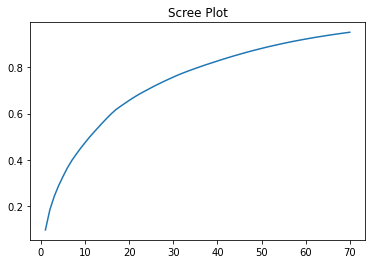

In [31]:
# making a scree plot

var_cumu = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1,len(var_cumu)+1), var_cumu)

plt.title("Scree Plot")
plt.show()

### Base Models

In [32]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
    

# XGBoost
xgclf = xgb.XGBClassifier()
xgclf_pca = xgb.XGBClassifier()

# Logistic Regression
logreg = LogisticRegression(random_state=123)
logreg_pca = LogisticRegression(random_state=123)

# Random Forest
rfclf = RandomForestClassifier(n_estimators=50, random_state=123)
rfclf_pca = RandomForestClassifier(n_estimators=50, random_state=123)

xgclf.fit(X_train_scaled, y_train)
xgclf_pca.fit(X_train_pca, y_train)

logreg.fit(X_train_scaled, y_train)
logreg_pca.fit(X_train_pca, y_train)

rfclf.fit(X_train_scaled, y_train)
rfclf_pca.fit(X_train_pca, y_train)


RandomForestClassifier(n_estimators=50, random_state=123)

In [33]:
print('AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=xgclf.predict_proba(X_train_scaled)[:, 1]))

print('AUC on train data with PCA by XGBoost =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=xgclf_pca.predict_proba(X_train_pca)[:, 1]))


print('AUC on train data by LogisticRegression =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=logreg.predict_proba(X_train_scaled)[:, 1]))

print('AUC on train data with PCA by LogisticRegression =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=logreg_pca.predict_proba(X_train_pca)[:, 1]))

print('AUC on train data by RF =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=rfclf.predict_proba(X_train_scaled)[:, 1]))

print('AUC on train data with PCA by RF =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=rfclf_pca.predict_proba(X_train_pca)[:, 1]))                                                             

AUC on train data by XGBoost = 1.0
AUC on train data with PCA by XGBoost = 1.0
AUC on train data by LogisticRegression = 0.9007864236964652
AUC on train data with PCA by LogisticRegression = 0.8979465182978732
AUC on train data by RF = 1.0
AUC on train data with PCA by RF = 1.0


In [34]:
print('AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=xgclf.predict_proba(X_test_scaled)[:, 1]))

print('AUC on test data with PCA by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=xgclf_pca.predict_proba(X_test_pca)[:, 1]))


print('AUC on test data by LogisticRegression =', metrics.roc_auc_score(y_true=y_test,
                                                              y_score=logreg.predict_proba(X_test_scaled)[:, 1]))

print('AUC on test data with PCA by LogisticRegression =', metrics.roc_auc_score(y_true=y_test,
                                                              y_score=logreg_pca.predict_proba(X_test_pca)[:, 1]))           

print('AUC on test data by RF =', metrics.roc_auc_score(y_true=y_test,
                                                              y_score=rfclf.predict_proba(X_test_scaled)[:, 1]))

print('AUC on test data with PCA by RF =', metrics.roc_auc_score(y_true=y_test,
                                                              y_score=rfclf_pca.predict_proba(X_test_pca)[:, 1]))   

AUC on test data by XGBoost = 0.9302511675457142
AUC on test data with PCA by XGBoost = 0.857535723413648
AUC on test data by LogisticRegression = 0.8765956458096146
AUC on test data with PCA by LogisticRegression = 0.8740472594623481
AUC on test data by RF = 0.9155542647366344
AUC on test data with PCA by RF = 0.8355133715932062


In [35]:
print("Xgboost test recall without PCA:",metrics.recall_score(y_test, xgclf.predict(X_test_scaled)))
print("Xgboost test recall with PCA:",metrics.recall_score(y_test, xgclf_pca.predict(X_test_pca)))

print("Logistic regression test recall without PCA:",metrics.recall_score(y_test, logreg.predict(X_test_scaled)))
print("Logistic regression test recall with PCA:",metrics.recall_score(y_test, logreg_pca.predict(X_test_pca)))

print("RF test recall without PCA:",metrics.recall_score(y_test, rfclf.predict(X_test_scaled)))
print("RF test recall with PCA:",metrics.recall_score(y_test, rfclf_pca.predict(X_test_pca)))

Xgboost test recall without PCA: 0.29596412556053814
Xgboost test recall with PCA: 0.15246636771300448
Logistic regression test recall without PCA: 0.08968609865470852
Logistic regression test recall with PCA: 0.10762331838565023
RF test recall without PCA: 0.242152466367713
RF test recall with PCA: 0.02242152466367713


### Dealing with class imbalance - Undersampling

In [36]:
non_churn_train = raw_df_train[raw_df_train['churn'] == 0]
churn_train = raw_df_train[raw_df_train['churn'] == 1]

print("Number of non-churn cases in train set:",len(non_churn_train))
print("Number of churn cases in train set:", len(churn_train))

Number of non-churn cases in train set: 19298
Number of churn cases in train set: 890


In [37]:
non_churn_sample = non_churn_train.sample(n=3*len(churn_train), random_state=123)

train_sample = pd.concat([non_churn_sample, churn_train], axis = 0)
train_sample = train_sample.sample(frac=1).reset_index(drop=True)

train_sample.shape

(3560, 140)

### Base models with undersampling

In [38]:
X_train_sample = train_sample[[col for col in train_sample.columns if col != 'churn']]
y_train_sample = train_sample['churn']

In [39]:
scaler_sampled = StandardScaler()
X_train_sample = scaler_sampled.fit_transform(X_train_sample)


In [40]:
# XGBoost
xgclf = xgb.XGBClassifier()

# Logistic Regression
logreg = LogisticRegression(random_state=123)

# Random Forest
rfclf = RandomForestClassifier(n_estimators=50, random_state=123)

xgclf.fit(X_train_sample, y_train_sample)

logreg.fit(X_train_sample, y_train_sample)

rfclf.fit(X_train_sample, y_train_sample)

RandomForestClassifier(n_estimators=50, random_state=123)

In [41]:
print('AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=xgclf.predict_proba(X_test_scaled)[:, 1]))

print('AUC on test data by LogisticRegression =', metrics.roc_auc_score(y_true=y_test,
                                                              y_score=logreg.predict_proba(X_test_scaled)[:, 1]))
         
print('AUC on test data by RF =', metrics.roc_auc_score(y_true=y_test,
                                                              y_score=rfclf.predict_proba(X_test_scaled)[:, 1]))

AUC on test data by XGBoost = 0.8905792420827622
AUC on test data by LogisticRegression = 0.8847222286763169
AUC on test data by RF = 0.8659211412904575


In [42]:
print("Xgboost test recall without PCA:",metrics.recall_score(y_test, xgclf.predict(X_test_scaled)))

print("Logistic regression test recall without PCA:",metrics.recall_score(y_test, logreg.predict(X_test_scaled)))

print("RF test recall without PCA:",metrics.recall_score(y_test, rfclf.predict(X_test_scaled)))

Xgboost test recall without PCA: 0.7937219730941704
Logistic regression test recall without PCA: 0.7354260089686099
RF test recall without PCA: 0.757847533632287


### Hyperparameter tuning of Random Forest Model

In [43]:
from sklearn.model_selection import RandomizedSearchCV

rfclf = RandomForestClassifier(random_state=123, oob_score=True)

param_grid = {
    'n_estimators': np.arange(10,100,5),
    'max_depth': np.arange(3,30,3),
    'class_weight': [None, 'balanced'],
    'min_samples_split': [5,10,15,20]
}

rfclf_cv = RandomizedSearchCV(estimator=rfclf,
                            param_distributions=param_grid,
                            n_iter=200,
                            scoring='recall',
                            n_jobs=-1,
                            verbose=True)

rfclf_cv.fit(X_train_sample, y_train_sample)
print(rfclf_cv.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'n_estimators': 40, 'min_samples_split': 15, 'max_depth': 6, 'class_weight': 'balanced'}


In [44]:
print("Train scores:")
print("AUC score:",metrics.roc_auc_score(y_train, rfclf_cv.predict(X_train_scaled)))
print("Recall metrics:",metrics.recall_score(y_train, rfclf_cv.predict(X_train_scaled)),'\n')

print("Test Scores:")
print("Test AUC score:",metrics.roc_auc_score(y_test, rfclf_cv.predict(X_test_scaled)))
print("Test recall metrics:",metrics.recall_score(y_test, rfclf_cv.predict(X_test_scaled)))

Train scores:
AUC score: 0.7807486017646353
Recall metrics: 0.9617977528089887 

Test Scores:
Test AUC score: 0.7469044355119775
Test recall metrics: 0.905829596412556


### Explanatory Logistic Regression Model

In [65]:
C = [10, 1, .1, .01]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train_sample, y_train_sample)
    print('C:', c)
    print('Training accuracy:', clf.score(X_train_sample, y_train_sample))
    print('Test accuracy:', clf.score(X_test_scaled, y_test))
    print('')

C: 10
Training accuracy: 0.8632022471910112
Test accuracy: 0.8793581616481775

C: 1
Training accuracy: 0.8598314606741573
Test accuracy: 0.881339144215531

C: 0.1
Training accuracy: 0.8595505617977528
Test accuracy: 0.8918383518225039

C: 0.01
Training accuracy: 0.8300561797752809
Test accuracy: 0.9179873217115689



In [69]:
# Using C = 0.1

clf = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
clf.fit(X_train_sample, y_train_sample)
coeff_df = pd.DataFrame({'column_name':list(X_train.columns), 'coefficient':clf.coef_.flatten()})

In [70]:
# Top 10 features with a positive relation with churn
pos_10 = coeff_df.sort_values('coefficient', ascending=False).head(10)
pos_10

,column_name,coefficient
19,roam_og_mou_8,0.407227
66,loc_ic_t2m_mou_7,0.237455
47,std_og_mou_6,0.196218
18,roam_og_mou_7,0.183100
48,std_og_mou_7,0.165465
8,onnet_mou_6,0.143594
39,std_og_t2m_mou_7,0.138916
15,roam_ic_mou_7,0.115191
102,total_rech_num_7,0.112261
16,roam_ic_mou_8,0.091046


In [71]:
# Top 10 features with a negative relation with churn
neg_10 = coeff_df.sort_values('coefficient', ascending=True).head(10)
neg_10

,column_name,coefficient
73,loc_ic_mou_8,-1.148609
70,loc_ic_t2f_mou_8,-0.389332
61,total_og_mou_8,-0.352042
25,loc_og_t2m_mou_8,-0.324439
115,last_day_rch_amt_8,-0.318006
112,date_of_last_rech_8,-0.287149
7,arpu_8,-0.278072
103,total_rech_num_8,-0.277446
135,aug_vbc_3g,-0.234030
94,spl_ic_mou_8,-0.211709


### How to prevent customer churn?

- Track roaming and local activities of the customer
- If roaming activity of the customer has increased in the last 2 months, the customer is more likely to churn
- The more recent the recharge date, the less likely the customer is to churn
- Higher the recharge amount, lower the probability of churn